In [1]:
# Importing the libraries
import numpy as np 
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ast 
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
from datetime import timedelta, datetime
import openai
import time 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler
import os
# Show ALL columns
pd.set_option('display.max_columns', None)

# set openai api key
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
# Current OpenAI Balance: $9.93


In [2]:
#Load Datasets with Date Parsing 
inbound_shipments = pd.read_csv("inbound_shipments.csv", 
                                parse_dates=['created_date', 'updated_date', 'expected_arrival_date'])

inventory = pd.read_csv("inventory.csv", 
                        parse_dates=['created_date', 'updated_date'])

orders_line_items = pd.read_csv("orders_line_items.csv")

orders = pd.read_csv("orders.csv", 
                     parse_dates=['created_date', 'updated_date', 'required_ship_date'])

products = pd.read_csv("products.csv", 
                       parse_dates=['created_date', 'updated_date'])

shipping_methods = pd.read_csv("shipping_methods.csv", 
                               parse_dates=['created_date', 'updated_date'])

suppliers = pd.read_csv("suppliers.csv", 
                        parse_dates=['created_date', 'updated_date'])

#Inspect Datasets: Overview, Data Types, and Missing Values

# Define function for inspection
def inspect_dataset(name, df):
    print(f"\n{name} Dataset Overview:")
    print("\nHEAD:\n", df.head())
    print("\nINFO:\n")
    print(df.info())
    print("\nMISSING VALUES:\n", df.isnull().sum())
    print("\n" + "-"*80 + "\n")


# Run inspections
inspect_dataset("Products", products)
inspect_dataset("Inventory", inventory)
inspect_dataset("Orders Line Items", orders_line_items)
inspect_dataset("Orders", orders)
inspect_dataset("Inbound Shipments", inbound_shipments)
inspect_dataset("Shipping Methods", shipping_methods)
inspect_dataset("Suppliers", suppliers)


Products Dataset Overview:

HEAD:
                  id  warehouse_customer_id              created_date  \
0  AB10BBLK00_20494                  20494 2024-03-06 06:00:00+00:00   
1  AB10BBLK10_20494                  20494 2024-04-09 05:00:00+00:00   
2  AB10BBLK15_20494                  20494 2024-03-06 06:00:00+00:00   
3  AB10BBLK20_20494                  20494 2024-03-06 06:00:00+00:00   
4  AB10BBLK30_20494                  20494 2024-03-06 06:00:00+00:00   

               updated_date                        name         sku  \
0 2024-07-19 09:54:58+00:00    Abbey Blue-light Black 0  AB10BBLK00   
1 2024-07-17 11:11:18+00:00    Abbey Blue-light Black 1  AB10BBLK10   
2 2024-07-26 11:30:29+00:00  Abbey Blue-light Black 1.5  AB10BBLK15   
3 2024-07-23 11:00:46+00:00    Abbey Blue-light Black 2  AB10BBLK20   
4 2024-07-11 11:52:42+00:00    Abbey Blue-light Black 3  AB10BBLK30   

           gtin                                    inventory_items  is_kit  \
0  8.520550e+11  [{'invent


Total unique SKUs in products: 1267


/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1860/2507062824.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  products['year_month'] = products['created_date'].dt.to_period('M')


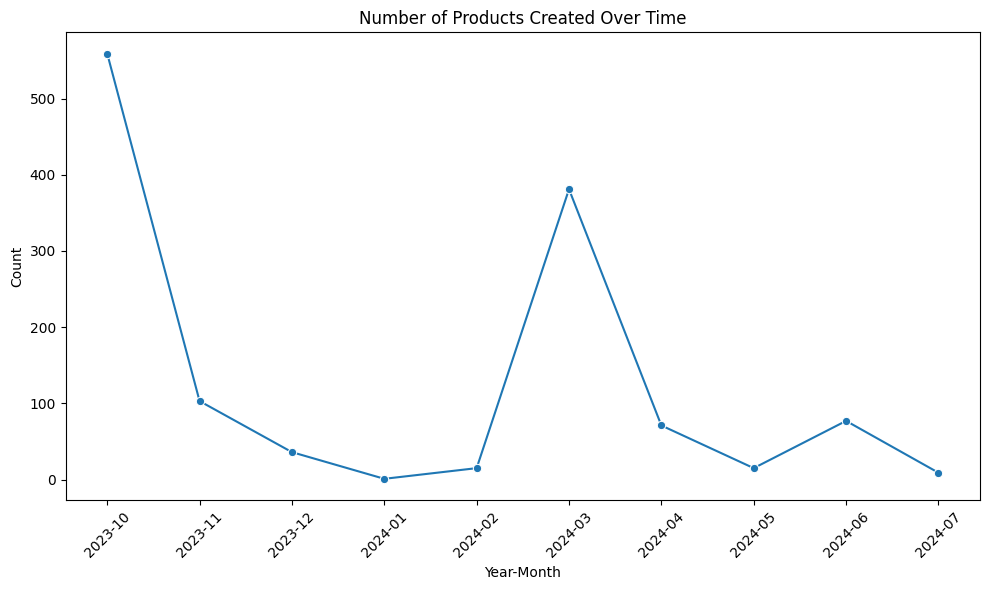


Active vs. Inactive Products:
active
True    1267
Name: count, dtype: int64

SKU Creation Counts by Month:
year_month  count
   2023-10    559
   2023-11    103
   2023-12     36
   2024-01      1
   2024-02     15
   2024-03    381
   2024-04     71
   2024-05     15
   2024-06     77
   2024-07      9


In [3]:
# SKUs: Starting with the Products Table

# Check unique SKUs and basic stats from products
unique_skus = products['sku'].nunique()
print(f"\nTotal unique SKUs in products: {unique_skus}")

# Distribution of product creation dates (by month)
products['year_month'] = products['created_date'].dt.to_period('M')
creation_counts = products.groupby('year_month').size().reset_index(name='count')
creation_counts['year_month'] = creation_counts['year_month'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(x='year_month', y='count', data=creation_counts, marker='o')
plt.title("Number of Products Created Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inspect product-level details (e.g., active status and missing values)
active_counts = products['active'].value_counts()
print("\nActive vs. Inactive Products:")
print(active_counts)

# Display table with SKU counts per month
print("\nSKU Creation Counts by Month:")
print(creation_counts.to_string(index=False))


There are 1267 total unique SKUs, and most were created in OCT 2023, with a spike in March 2024 


Inventory Statistics:
             onhand    committed      sellable
count   1267.000000  1267.000000   1267.000000
mean     154.258090    -3.631413    151.292818
std      659.963348   165.097637    658.555314
min        0.000000 -5558.000000     -3.000000
25%        5.000000     0.000000      4.000000
50%       36.000000     2.000000     34.000000
75%      102.500000     3.000000    100.000000
max    18808.000000    37.000000  18806.000000


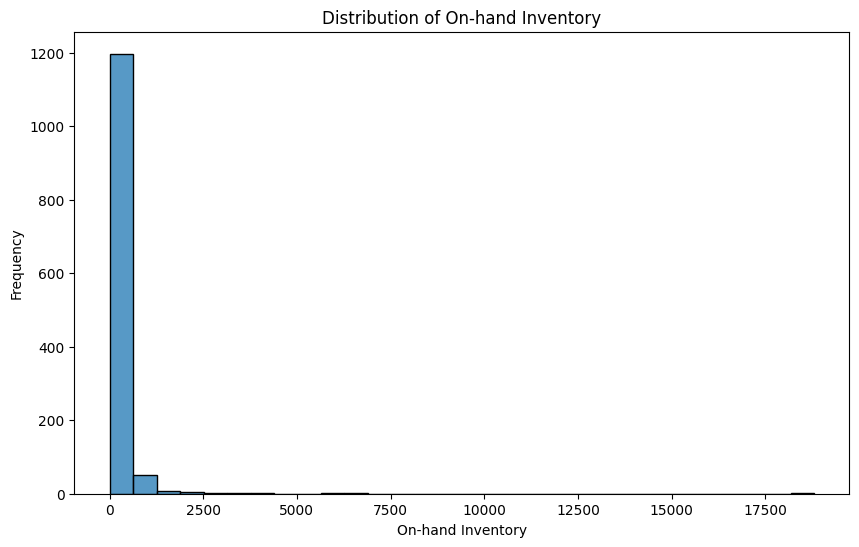

In [4]:
# EDA on Inventory: SKU-Level Inventory Details

# Look at key inventory columns (onhand, committed, sellable)
inventory_stats = inventory[['onhand', 'committed', 'sellable']].describe()
print("\nInventory Statistics:")
print(inventory_stats)

plt.figure(figsize=(10, 6))
sns.histplot(inventory['onhand'], bins=30)
plt.title("Distribution of On-hand Inventory")
plt.xlabel("On-hand Inventory")
plt.ylabel("Frequency")
plt.show()

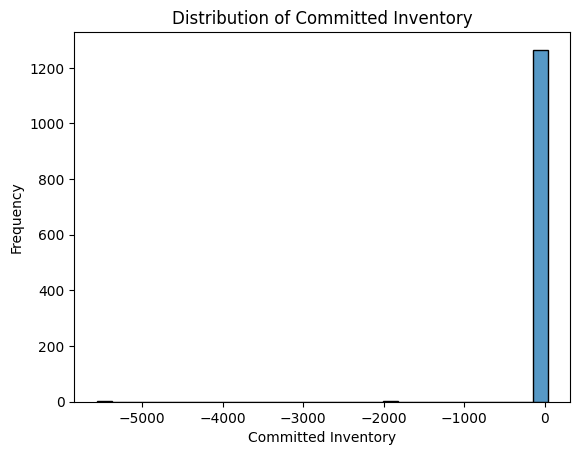

In [5]:
# Looking into inventory levels for outlier SKUs
inventory[inventory['committed'] < 0]
sns.histplot(inventory['committed'], bins=30)
plt.title("Distribution of Committed Inventory")
plt.xlabel("Committed Inventory")
plt.ylabel("Frequency")
plt.show()


This makes sense, but there is one SKU that stands out as an outlier with over 18,000 units in inventory. Additionally, some SKUs have negative committed and negative sellable inventory.

Possible reasons for negative committed inventory include:

Backorders – Orders placed but not yet replenished.
Stock adjustments/errors – Manual inventory corrections.
Returns or cancellations – Items that were committed to an order but later canceled.

In [6]:
# Extract unit_quantity from inventory_items
def extract_unit_quantity(item_list):
    if isinstance(item_list, str):  # If it's stored as a string, convert it to a list
        try:
            item_list = ast.literal_eval(item_list)
        except (ValueError, SyntaxError):
            return None  # Return None if conversion fails
    if isinstance(item_list, list) and len(item_list) > 0:
        return item_list[0].get('unit_quantity', None)  # Get unit_quantity from first item
    return None

# Apply extraction function
products['unit_quantity'] = products['inventory_items'].apply(extract_unit_quantity)

# Merge with inventory data
sku_data = pd.merge(
    products[['sku', 'name', 'id', 'created_date', 'unit_quantity']],
    inventory[['sku', 'awaiting', 'onhand', 'committed', 'unfulfillable', 'fulfillable', 'unsellable', 'sellable']],
    on='sku',
    how='left'
)

# Compare unit_quantity with sellable inventory
sku_data['unit_quantity_matches_sellable'] = sku_data['unit_quantity'] == sku_data['sellable']


sku_data

,sku,name,id,created_date,unit_quantity,awaiting,onhand,committed,unfulfillable,fulfillable,unsellable,sellable,unit_quantity_matches_sellable
0,AB10BBLK00,Abbey Blue-light Black 0,AB10BBLK00_20494,2024-03-06 06:00:00+00:00,129,0,129,0,0,129,0,129,True
1,AB10BBLK10,Abbey Blue-light Black 1,AB10BBLK10_20494,2024-04-09 05:00:00+00:00,1,0,0,0,0,0,0,0,False
2,AB10BBLK15,Abbey Blue-light Black 1.5,AB10BBLK15_20494,2024-03-06 06:00:00+00:00,6,0,6,0,0,6,0,6,True
3,AB10BBLK20,Abbey Blue-light Black 2,AB10BBLK20_20494,2024-03-06 06:00:00+00:00,63,0,63,0,0,63,0,63,True
4,AB10BBLK30,Abbey Blue-light Black 3,AB10BBLK30_20494,2024-03-06 06:00:00+00:00,34,0,34,0,0,34,0,34,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,WI80SBLK15,Wills Sun Black 1.5,WI80SBLK15_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False
1263,WI80SBLK20,Wills Sun Black 2,WI80SBLK20_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False
1264,WI80SBLK25,Wills Sun Black 2.5,WI80SBLK25_20494,2024-04-09 05:00:00+00:00,1,0,0,0,0,0,0,0,False
1265,WI80SNTP10,Wills Sun Navy Taupe 1,WI80SNTP10_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False


The unit_quantity extracted from inventory_items in the products table does not consistently match the sellable or onhand inventory in the inventory dataset. This discrepancy raises uncertainty about which source should be used to track inventory levels accurately. If inventory_items reflects the intended stock per SKU but differs from the inventory records, there may be data synchronization issues, reporting inconsistencies, or missing updates.

In [7]:
# EDA on Sales Data: Orders and Order Line Items

# Merge order dates into orders_line_items to add a time dimension to sales
# This merge assumes that the 'id' column in orders_line_items corresponds to orders.id.

orders_line_items = orders_line_items.merge(
    orders[['id', 'created_date']],
    left_on='id', 
    right_on='id',
    how='left'
)
orders_line_items.rename(columns={'created_date': 'order_date'}, inplace=True)

# Compute total units sold per SKU from orders_line_items
sales_by_sku = orders_line_items.groupby('sku')['quantity'].sum().reset_index(name='total_quantity_sold')
print("\nTop 10 SKUs by Sales Volume:")
print(sales_by_sku.sort_values(by='total_quantity_sold', ascending=False).head(10))
orders_line_items



Top 10 SKUs by Sales Volume:
            sku  total_quantity_sold
359  CO70PTPE15                 4859
360  CO70PTPE20                 3391
715  LA40PTOR15                 3198
349  CO70PTOR15                 2914
324  CO70PCHA15                 2593
700  LA40PCHA15                 2389
716  LA40PTOR20                 2263
413   CO70TPE15                 2137
319  CO70PBLK15                 2060
361  CO70PTPE25                 2054


,product_id,sku,quantity,unit_price,is_picked,discount_amount,id,order_date
0,CO70BLK10_20494,CO70BLK10,1,44.2,True,NaN,1000033.0,2023-11-25 09:01:00+00:00
1,CO70CRN10_20494,CO70CRN10,1,68.0,True,NaN,1000033.0,2023-11-25 09:01:00+00:00
2,CO70LKB10_20494,CO70LKB10,1,68.0,True,NaN,1000033.0,2023-11-25 09:01:00+00:00
3,BO20SGB15_20494,BO20SGB15,1,68.0,True,NaN,1000063.0,2023-11-25 09:42:00+00:00
4,SU30PNAV15_20494,SU30PNAV15,1,98.0,True,NaN,1000063.0,2023-11-25 09:42:00+00:00
...,...,...,...,...,...,...,...,...
192611,LA40PNAV15_20494,LA40PNAV15,1,98.0,True,NaN,999996.0,2023-11-25 08:21:00+00:00
192612,CO70PTOR15_20494,CO70PTOR15,1,98.0,True,NaN,999997.0,2023-11-25 08:21:00+00:00
192613,SU30TOR15_20494,SU30TOR15,1,68.0,True,NaN,999997.0,2023-11-25 08:21:00+00:00
192614,CO70PTOR15_20494,CO70PTOR15,1,98.0,True,NaN,999998.0,2023-11-25 08:21:00+00:00


In this EDA step, I merged order dates from the orders dataset into orders_line_items, adding a time dimension to each SKU’s sales data. This ensures that every line item now has an associated order date, making it possible to analyze sales trends over time. I then calculated the total quantity sold per SKU, identifying the top-selling products. From the output, SKUs like CO70PTPE15 and CO70PTPE20 stand out with thousands of units sold, indicating they are high-demand products. This analysis helps in understanding which SKUs drive the most sales volume and can inform inventory planning, pricing strategies, and promotional efforts.

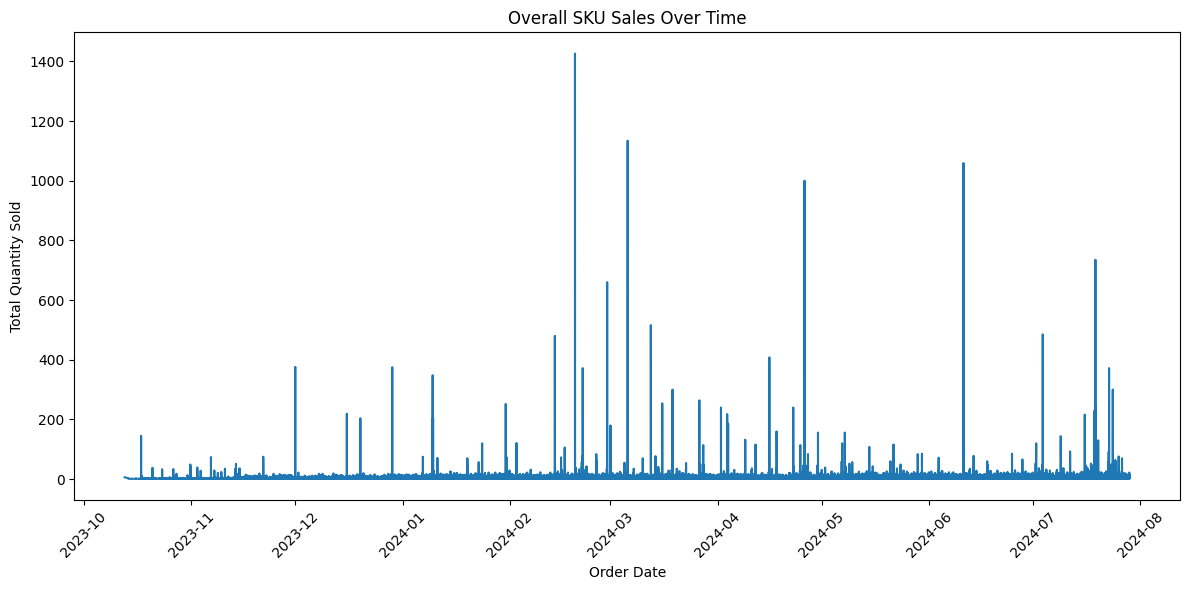

In [8]:
# Time Series Analysis of Sales
# Aggregate total sales (quantity) by order date to observe overall trends
sales_trend = orders_line_items.groupby('order_date')['quantity'].sum().reset_index(name='total_quantity_sold')

plt.figure(figsize=(12, 6))
sns.lineplot(x='order_date', y='total_quantity_sold', data=sales_trend)
plt.title("Overall SKU Sales Over Time")
plt.xlabel("Order Date")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
fig = px.line(
    sales_trend,
    x='order_date',
    y='total_quantity_sold',
    title='Interactive Overall Sales Time Series',
    labels={'order_date': 'Order Date', 'total_quantity_sold': 'Total Quantity Sold'}
)
fig.show()


This time series analysis aggregates total SKU sales (quantity sold) per order date to observe overall sales trends over time. From the graph, we can see spikes in sales activity, which may correspond to promotional campaigns, seasonal demand, or bulk purchases. The high variability suggests that certain days experience significantly higher sales, potentially due to specific events such as flash sales, product launches, or restocks.

In [10]:
# Compute total quantity sold per SKU
total_quantity_sold = orders_line_items.groupby('sku')['quantity'].sum().reset_index()
total_quantity_sold.rename(columns={'quantity': 'total_quantity_sold'}, inplace=True)

# Compute average unit price per SKU
avg_unit_price = orders_line_items.groupby('sku')['unit_price'].mean().reset_index()
avg_unit_price.rename(columns={'unit_price': 'avg_unit_price'}, inplace=True)

# Group order details: order date, quantity, and price per SKU
order_details = orders_line_items.groupby('sku', group_keys=False).apply(
    lambda x: list(zip(x['order_date'], x['quantity'], x['unit_price']))
).reset_index(name='order_history')

# Merge sales data into sku_data
sku_data = sku_data.merge(total_quantity_sold, on='sku', how='left')
sku_data = sku_data.merge(avg_unit_price, on='sku', how='left')
sku_data = sku_data.merge(order_details, on='sku', how='left')

# Fill NaN values with appropriate defaults (corrected version)
sku_data = sku_data.assign(
    total_quantity_sold=sku_data['total_quantity_sold'].fillna(0),
    avg_unit_price=sku_data['avg_unit_price'].fillna(0),
    order_history=sku_data['order_history'].fillna("No Sales")
)

# Display updated sku_data
print(sku_data)

# Display info about sku_data
print("\nSKU Data Info:")
print(sku_data.info())

# Display summary statistics for sku_data
print("\nSKU Data Summary Statistics:")
print(sku_data.describe())


             sku                        name                id  \
0     AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1     AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2     AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3     AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4     AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   
...          ...                         ...               ...   
1262  WI80SBLK15         Wills Sun Black 1.5  WI80SBLK15_20494   
1263  WI80SBLK20           Wills Sun Black 2  WI80SBLK20_20494   
1264  WI80SBLK25         Wills Sun Black 2.5  WI80SBLK25_20494   
1265  WI80SNTP10      Wills Sun Navy Taupe 1  WI80SNTP10_20494   
1266  WI80SNTP20      Wills Sun Navy Taupe 2  WI80SNTP20_20494   

                  created_date  unit_quantity  awaiting  onhand  committed  \
0    2024-03-06 06:00:00+00:00            129         0     129          0   
1    2024-04-09 05:00:00+00:00              1      

/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1860/1303018594.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [11]:
sku_data

,sku,name,id,created_date,unit_quantity,awaiting,onhand,committed,unfulfillable,fulfillable,unsellable,sellable,unit_quantity_matches_sellable,total_quantity_sold,avg_unit_price,order_history
0,AB10BBLK00,Abbey Blue-light Black 0,AB10BBLK00_20494,2024-03-06 06:00:00+00:00,129,0,129,0,0,129,0,129,True,33.0,52.909091,"[(2024-04-03 17:03:00+00:00, 1, 42.0), (2024-0..."
1,AB10BBLK10,Abbey Blue-light Black 1,AB10BBLK10_20494,2024-04-09 05:00:00+00:00,1,0,0,0,0,0,0,0,False,6.0,71.333333,"[(2024-04-19 00:06:00+00:00, 1, 88.0), (2024-0..."
2,AB10BBLK15,Abbey Blue-light Black 1.5,AB10BBLK15_20494,2024-03-06 06:00:00+00:00,6,0,6,0,0,6,0,6,True,20.0,54.222222,"[(2024-03-30 07:17:00+00:00, 1, 66.0), (2024-0..."
3,AB10BBLK20,Abbey Blue-light Black 2,AB10BBLK20_20494,2024-03-06 06:00:00+00:00,63,0,63,0,0,63,0,63,True,23.0,72.752174,"[(2024-03-29 18:22:00+00:00, 1, 88.0), (2024-0..."
4,AB10BBLK30,Abbey Blue-light Black 3,AB10BBLK30_20494,2024-03-06 06:00:00+00:00,34,0,34,0,0,34,0,34,True,6.0,88.000000,"[(2024-03-27 15:42:00+00:00, 1, 88.0), (2024-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,WI80SBLK15,Wills Sun Black 1.5,WI80SBLK15_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False,11.0,80.181818,"[(2024-03-22 22:01:00+00:00, 1, 82.0), (2024-0..."
1263,WI80SBLK20,Wills Sun Black 2,WI80SBLK20_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False,5.0,82.000000,"[(2024-03-20 16:42:00+00:00, 1, 82.0), (2024-0..."
1264,WI80SBLK25,Wills Sun Black 2.5,WI80SBLK25_20494,2024-04-09 05:00:00+00:00,1,0,0,0,0,0,0,0,False,5.0,82.000000,"[(2024-04-27 13:25:00+00:00, 1, 82.0), (2024-0..."
1265,WI80SNTP10,Wills Sun Navy Taupe 1,WI80SNTP10_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False,1.0,82.000000,"[(2024-06-21 08:26:00+00:00, 1, 82.0)]"


This dataset now combines inventory and sales data at the SKU level, enabling a comprehensive analysis of product performance. Each SKU includes total quantity sold, average unit price, and detailed order history, showing when and at what price each unit was purchased. This allows for trend analysis, demand forecasting, and pricing optimization.

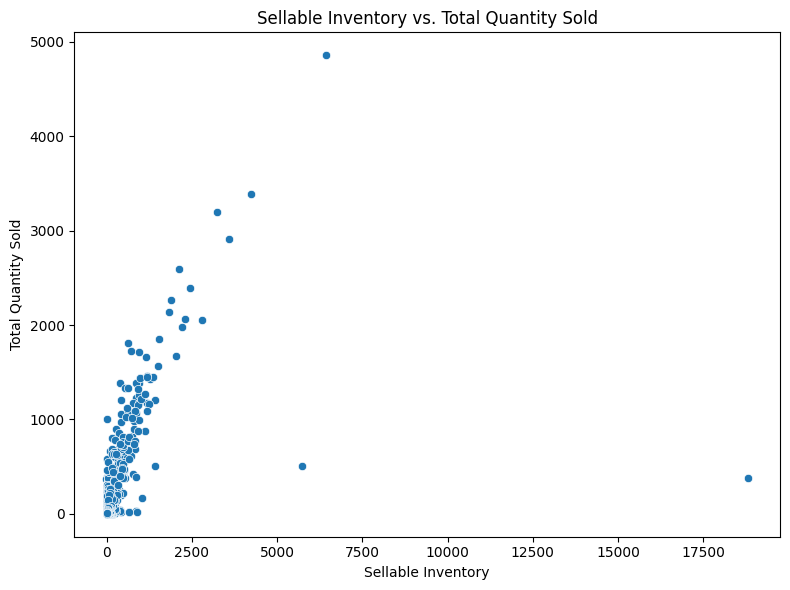

In [12]:
# Explore Relationships: Inventory vs. Sales
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sellable', y='total_quantity_sold', data=sku_data)
plt.title("Sellable Inventory vs. Total Quantity Sold")
plt.xlabel("Sellable Inventory")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

This scatterplot visualizes the relationship between the available sellable inventory and the total quantity sold per SKU. By plotting ‘sellable’ on the x-axis and ‘total_quantity_sold’ on the y-axis, we can assess whether higher inventory availability correlates with increased sales. The code uses seaborn’s scatterplot and is properly sized with labels and a tight layout to ensure clarity. This graph is useful for identifying potential bottlenecks or excesses in inventory relative to sales performance.

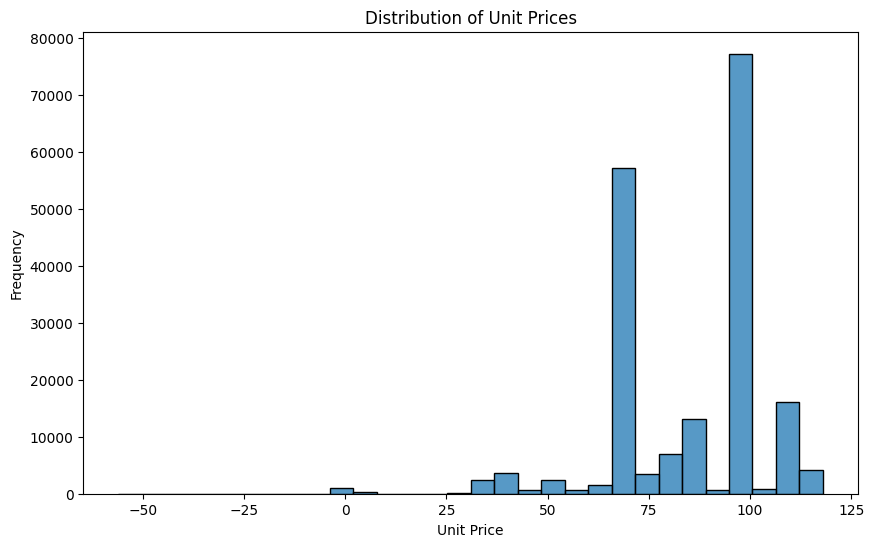

In [13]:
# Unit Price Distribution (from orders_line_items)
# Check distribution of unit prices (excluding missing values)
plt.figure(figsize=(10, 6))
sns.histplot(orders_line_items['unit_price'].dropna(), bins=30)
plt.title("Distribution of Unit Prices")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.show()

The histogram displays the distribution of unit prices from the orders_line_items dataset. By excluding missing values and setting an appropriate number of bins, the plot helps reveal the most common price ranges and whether the distribution is skewed. This analysis can uncover pricing clusters or outliers, which might suggest the presence of premium products or potential pricing errors. 

In [14]:
# Identify SKUs with No Sales
no_sales_count = sku_data[sku_data['total_quantity_sold'] == 0].shape[0]
print(f"\nNumber of SKUs with no recorded sales: {no_sales_count}")


Number of SKUs with no recorded sales: 46


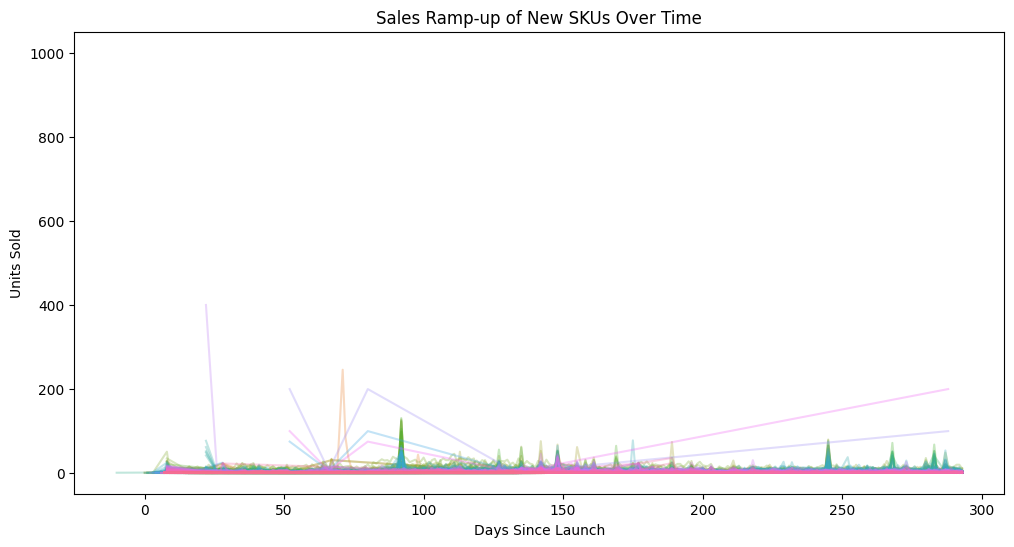

In [15]:
# Filter for new SKUs (e.g., created in last X months)
sku_launch_dates = products[['sku', 'created_date']]
sales_with_dates = orders_line_items.merge(sku_launch_dates, on='sku', how='left')

# Compute cumulative sales over time per SKU
sales_with_dates['days_since_launch'] = (sales_with_dates['order_date'] - sales_with_dates['created_date']).dt.days
sku_sales_trend = sales_with_dates.groupby(['sku', 'days_since_launch'])['quantity'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sku_sales_trend, x='days_since_launch', y='quantity', hue='sku', alpha=0.3, legend=False)
plt.title("Sales Ramp-up of New SKUs Over Time")
plt.xlabel("Days Since Launch")
plt.ylabel("Units Sold")
plt.show()



/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1860/1277024124.py:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




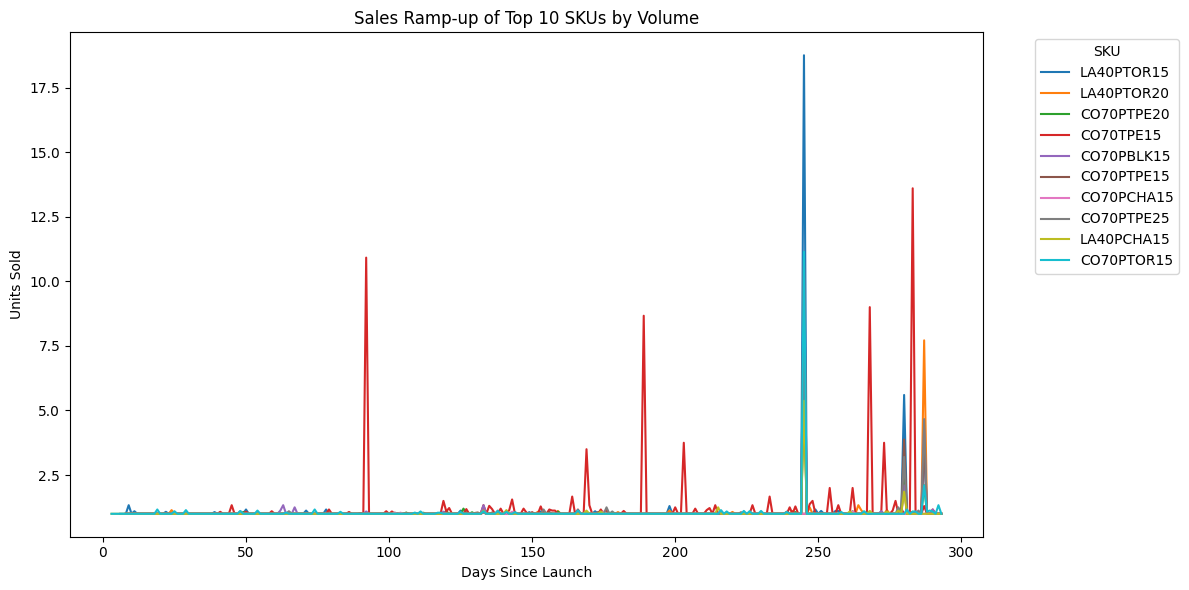

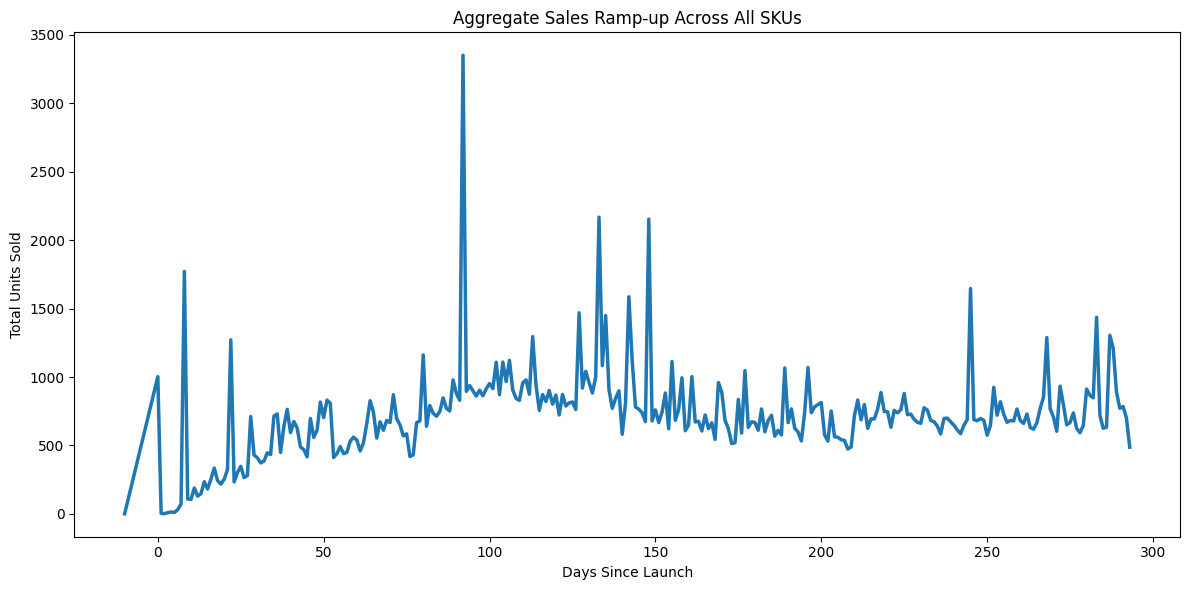

In [16]:

# 1. Sample top SKUs by sales volume
top_skus = sales_with_dates.groupby('sku')['quantity'].sum().nlargest(10).index
top_sku_sales = sales_with_dates[sales_with_dates['sku'].isin(top_skus)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_sku_sales, x='days_since_launch', y='quantity', hue='sku', ci=None)
plt.title("Sales Ramp-up of Top 10 SKUs by Volume")
plt.xlabel("Days Since Launch")
plt.ylabel("Units Sold")
plt.legend(title='SKU', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Aggregate sales by days since launch across all SKUs
daily_sales_all_skus = sales_with_dates.groupby('days_since_launch')['quantity'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sales_all_skus, x='days_since_launch', y='quantity', linewidth=2.5)
plt.title("Aggregate Sales Ramp-up Across All SKUs")
plt.xlabel("Days Since Launch")
plt.ylabel("Total Units Sold")
plt.tight_layout()
plt.show()

In [17]:
sales_with_dates

,product_id,sku,quantity,unit_price,is_picked,discount_amount,id,order_date,created_date,days_since_launch
0,CO70BLK10_20494,CO70BLK10,1,44.2,True,NaN,1000033.0,2023-11-25 09:01:00+00:00,2023-10-09 05:00:00+00:00,47
1,CO70CRN10_20494,CO70CRN10,1,68.0,True,NaN,1000033.0,2023-11-25 09:01:00+00:00,2023-10-09 05:00:00+00:00,47
2,CO70LKB10_20494,CO70LKB10,1,68.0,True,NaN,1000033.0,2023-11-25 09:01:00+00:00,2023-10-09 05:00:00+00:00,47
3,BO20SGB15_20494,BO20SGB15,1,68.0,True,NaN,1000063.0,2023-11-25 09:42:00+00:00,2023-10-09 05:00:00+00:00,47
4,SU30PNAV15_20494,SU30PNAV15,1,98.0,True,NaN,1000063.0,2023-11-25 09:42:00+00:00,2023-10-09 05:00:00+00:00,47
...,...,...,...,...,...,...,...,...,...,...
192611,LA40PNAV15_20494,LA40PNAV15,1,98.0,True,NaN,999996.0,2023-11-25 08:21:00+00:00,2023-10-09 05:00:00+00:00,47
192612,CO70PTOR15_20494,CO70PTOR15,1,98.0,True,NaN,999997.0,2023-11-25 08:21:00+00:00,2023-10-09 05:00:00+00:00,47
192613,SU30TOR15_20494,SU30TOR15,1,68.0,True,NaN,999997.0,2023-11-25 08:21:00+00:00,2023-10-09 05:00:00+00:00,47
192614,CO70PTOR15_20494,CO70PTOR15,1,98.0,True,NaN,999998.0,2023-11-25 08:21:00+00:00,2023-10-09 05:00:00+00:00,47


SKU Launch Performance Over Time. Can be used to identify early sales trends for newly launched SKUs but we have to clean up the graph a bit. This analysis focuses on new SKUs by merging the product launch dates with the orders data and computing the number of days since launch for each order. The resulting line plot, which overlays the daily sales (aggregated by SKU) with each SKU represented by a semi-transparent line, illustrates the ramp-up process of sales over time. The graph enables us to visually compare how quickly different new SKUs start accumulating sales, providing insight into early product performance and market acceptance. 

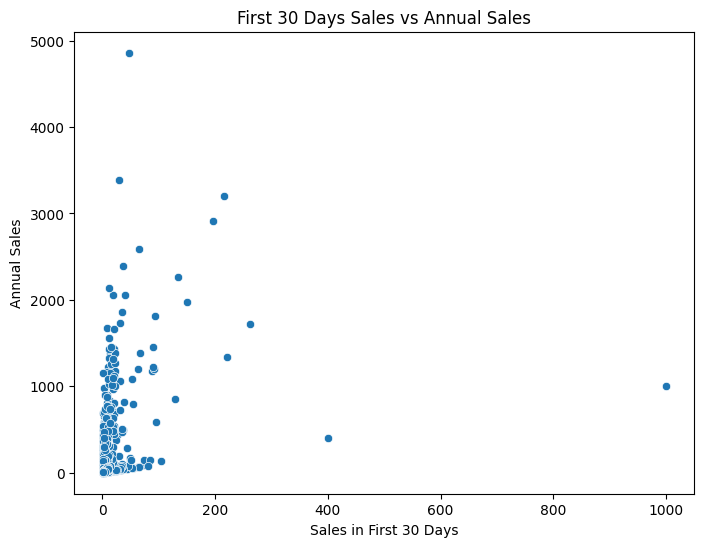

In [18]:
# Compute sales in first 30, 60, 90 days and compare with total sales
first_30_days_sales = sales_with_dates[sales_with_dates['days_since_launch'] <= 30].groupby('sku')['quantity'].sum().reset_index(name='first_30_days')
total_sales = sales_with_dates.groupby('sku')['quantity'].sum().reset_index(name='annual_sales')

sales_correlation = first_30_days_sales.merge(total_sales, on='sku')

plt.figure(figsize=(8, 6))
sns.scatterplot(data=sales_correlation, x='first_30_days', y='annual_sales')
plt.title("First 30 Days Sales vs Annual Sales")
plt.xlabel("Sales in First 30 Days")
plt.ylabel("Annual Sales")
plt.show()


the code aggregates sales in the first 30 days post-launch for each SKU and compares these to the total annual sales using a scatterplot. This plot helps determine whether strong early sales performance is indicative of overall annual sales success. A positive correlation would suggest that early momentum could be a reliable predictor of long-term performance. The visualization is clearly labeled, facilitating an easy comparison between early and total sales volumes.

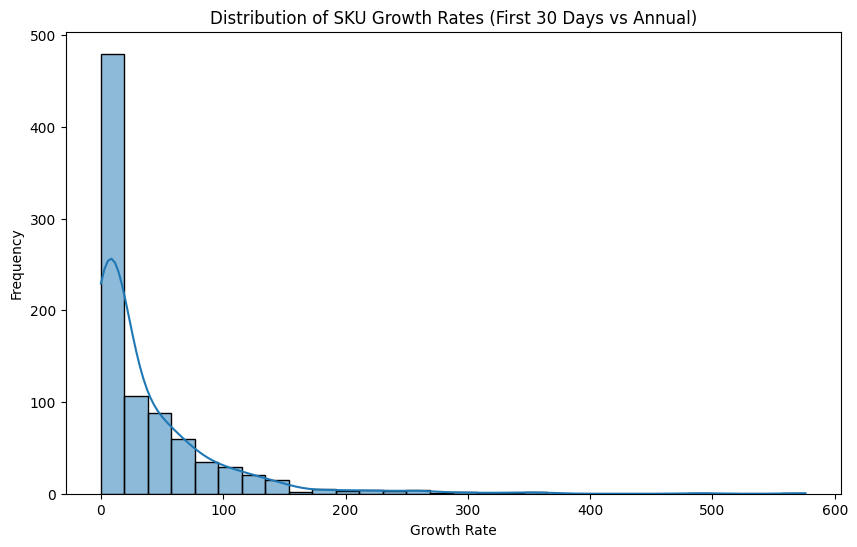

In [19]:
# Compute growth rates for early vs. later periods
sales_growth = sales_correlation.assign(
    growth_rate = (sales_correlation['annual_sales'] - sales_correlation['first_30_days']) / sales_correlation['first_30_days']
)

plt.figure(figsize=(10, 6))
sns.histplot(sales_growth['growth_rate'], bins=30, kde=True)
plt.title("Distribution of SKU Growth Rates (First 30 Days vs Annual)")
plt.xlabel("Growth Rate")
plt.ylabel("Frequency")
plt.show()


Growth rates are computed by comparing the annual sales to the first 30 days’ sales for each SKU. The histogram (with a kernel density estimate) displays the distribution of these growth rates, highlighting how rapidly sales expand beyond the initial launch period. This analysis provides an understanding of the variability in post-launch growth across SKUs. The code calculates the growth rate and then visualizes the distribution, allowing you to identify which SKUs experience accelerated growth relative to their initial performance.

In [20]:
inspect_dataset("sku", sku_data)



sku Dataset Overview:

HEAD:
           sku                        name                id  \
0  AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1  AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2  AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3  AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4  AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   

               created_date  unit_quantity  awaiting  onhand  committed  \
0 2024-03-06 06:00:00+00:00            129         0     129          0   
1 2024-04-09 05:00:00+00:00              1         0       0          0   
2 2024-03-06 06:00:00+00:00              6         0       6          0   
3 2024-03-06 06:00:00+00:00             63         0      63          0   
4 2024-03-06 06:00:00+00:00             34         0      34          0   

   unfulfillable  fulfillable  unsellable  sellable  \
0              0          129           0       129   
1              0            0

In [21]:

# ---- helper to explode inbound line_items ----------------------------------
def explode_line_items(df, date_col='created_date'):
    records = []
    for _, row in df.iterrows():
        items = row['line_items']
        if pd.isna(items):
            continue
        for d in ast.literal_eval(items):
            qty = (d.get('quantity')        # adjust if your key is different
                   or d.get('qty')
                   or d.get('received_quantity'))
            records.append({
                'sku'        : d['sku'],
                'recv_qty'   : qty,
                'recv_date'  : row[date_col]   # keep the shipment timestamp
            })
    return pd.DataFrame(records)

# 1) flatten inbound shipments with their dates
recv_long = explode_line_items(inbound_shipments)

# 2) merge SKU created_date into the receipts frame
recv_long = recv_long.merge(
    sku_data[['sku', 'created_date']], on='sku', how='left'
)

# 3) flag receipts that happened AFTER the SKU record was created
recv_after = (recv_long[recv_long['recv_date'] > recv_long['created_date']]
              .groupby('sku', as_index=False)['recv_qty']
              .sum()
              .rename(columns={'recv_qty': 'receipts_after'}))

# 4) bring the “after” receipts into sku_data
sku_data = (sku_data
            .merge(recv_after, on='sku', how='left')
            .fillna({'receipts_after': 0}))

# 5) compute initial inventory
sku_data['initial_inventory'] = (
        sku_data['unit_quantity']
      + sku_data['total_quantity_sold']
      - sku_data['receipts_after']
)

# quick sanity check
neg = sku_data[sku_data['initial_inventory'] < 0]
zero = sku_data[sku_data['initial_inventory'] == 0]
print(f"Negative initial‑inv SKUs: {len(neg)},   Zero initial‑inv SKUs: {len(zero)}")
print("Negative initial inventory SKUs:")
print(neg['name'])
print("Zero initial inventory SKUs:")
print(zero)


Negative initial‑inv SKUs: 1,   Zero initial‑inv SKUs: 34
Negative initial inventory SKUs:
947    Medium Box 2 pc
Name: name, dtype: object
Zero initial inventory SKUs:
            sku                                      name                id  \
450  CO71PLKB10       Cosmo Mini Progressives Lake Blue 1  CO71PLKB10_20494   
618   KT01BTG10      Keaton Readers Tortoise Green Tint 1   KT01BTG10_20494   
622   KT01BTG30      Keaton Readers Tortoise Green Tint 3   KT01BTG30_20494   
623  KT01PBTG10          Keaton Progressives Green Tint 1  KT01PBTG10_20494   
624  KT01PBTG15        Keaton Progressives Green Tint 1.5  KT01PBTG15_20494   
625  KT01PBTG20          Keaton Progressives Green Tint 2  KT01PBTG20_20494   
626  KT01PBTG25        Keaton Progressives Green Tint 2.5  KT01PBTG25_20494   
627  KT01PBTG30          Keaton Progressives Green Tint 3  KT01PBTG30_20494   
628  KT01PSCB10  Keaton Progressives Cinnamon Blue Tint 1  KT01PSCB10_20494   
629  KT01PSCB15     Keaton Progressives C

We flatten the inbound_shipments.line_items field, tag each receipt with its shipment date, and sum only those quantities that occurred after the SKU’s own created_date. Then we compute initial_inventory by adding current units and lifetime sales and subtracting those post‑launch receipts, yielding the stock level that must have existed on day one.

In [22]:
inspect_dataset("sku", sku_data)



sku Dataset Overview:

HEAD:
           sku                        name                id  \
0  AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1  AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2  AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3  AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4  AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   

               created_date  unit_quantity  awaiting  onhand  committed  \
0 2024-03-06 06:00:00+00:00            129         0     129          0   
1 2024-04-09 05:00:00+00:00              1         0       0          0   
2 2024-03-06 06:00:00+00:00              6         0       6          0   
3 2024-03-06 06:00:00+00:00             63         0      63          0   
4 2024-03-06 06:00:00+00:00             34         0      34          0   

   unfulfillable  fulfillable  unsellable  sellable  \
0              0          129           0       129   
1              0            0

Number of new SKUs (created after 2024-05-01): 101
           sku              created_date
237  CA60NAV10 2024-07-18 05:00:00+00:00
238  CA60NAV15 2024-07-18 05:00:00+00:00
239  CA60NAV20 2024-07-18 05:00:00+00:00
240  CA60NAV25 2024-07-18 05:00:00+00:00
241  CA60NAV30 2024-07-18 05:00:00+00:00

Sample new SKU orders with days_since_launch:
          sku                order_date              created_date  \
0  LI50XTOR15 2024-06-15 00:25:00+00:00 2024-05-14 05:00:00+00:00   
1  LI50XTOR25 2024-06-15 03:05:00+00:00 2024-05-14 05:00:00+00:00   
2  LI50XTOR15 2024-06-15 16:21:00+00:00 2024-05-14 05:00:00+00:00   
3  LI50XTOR25 2024-06-15 16:24:00+00:00 2024-05-14 05:00:00+00:00   
4  LI50XTOR20 2024-06-15 16:44:00+00:00 2024-05-14 05:00:00+00:00   

   days_since_launch  quantity  
0                 31         1  
1                 31         1  
2                 32         1  
3                 32         1  
4                 32         1  

Daily sales for new SKUs (first 15 rows):


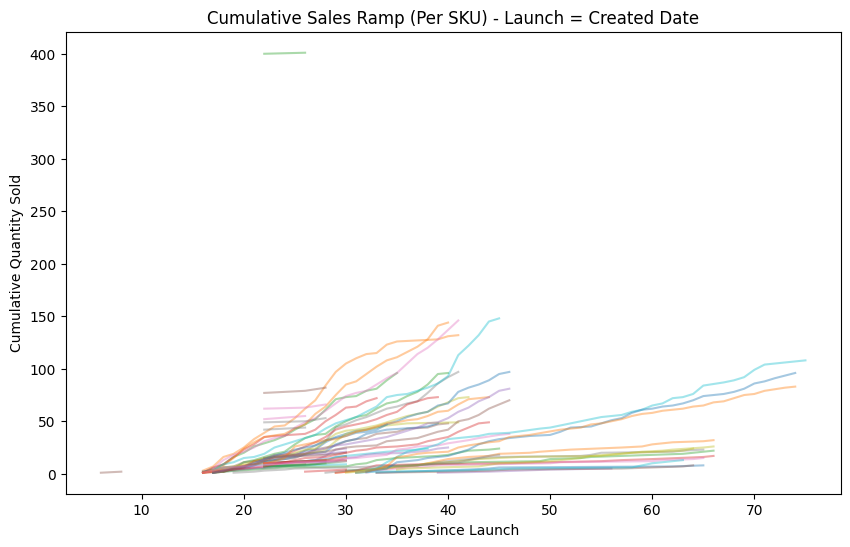

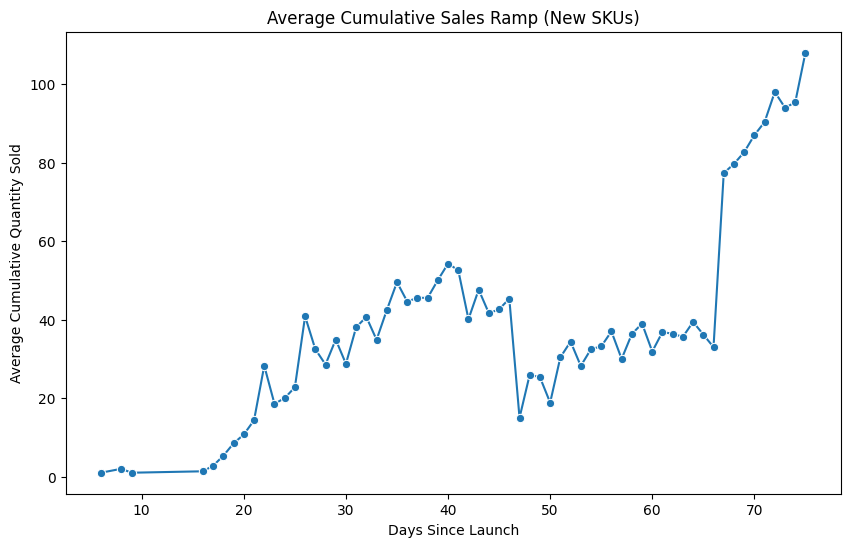

In [23]:
# Cutoff for new SKUs

cutoff_date = pd.Timestamp('2024-05-01', tz='UTC')

# Filter products down to new SKUs only
new_skus_df = products.loc[products['created_date'] >= cutoff_date, 
                           ['sku', 'created_date']].copy()

print(f"Number of new SKUs (created after {cutoff_date.date()}): {len(new_skus_df)}")
print(new_skus_df.head())

# Merge with order line items 
# Only keep rows for those new SKUs
# This ensures each line has the 'created_date' (treated as launch date).

orders_line_new = pd.merge(
    orders_line_items,
    new_skus_df,
    on='sku',
    how='inner'  # Only SKUs that appear in new_skus_df
)


# Calculate days since launch for each order

orders_line_new['days_since_launch'] = (
    orders_line_new['order_date'] - orders_line_new['created_date']
).dt.days


print("\nSample new SKU orders with days_since_launch:")
print(orders_line_new[['sku','order_date','created_date','days_since_launch','quantity']].head())

# Aggregate daily sales for each SKU
# Then compute a cumulative sum for each SKU to track its "ramp."
daily_sales = (
    orders_line_new
    .groupby(['sku','days_since_launch'], as_index=False)['quantity']
    .sum()
    .sort_values(['sku','days_since_launch'])
)

# Add a cumulative sum to see how total sales ramp up
daily_sales['cumulative_qty'] = (
    daily_sales.groupby('sku')['quantity'].cumsum()
)

print("\nDaily sales for new SKUs (first 15 rows):")
print(daily_sales.head(15))

# Plot the cumulative sales ramp for each SKU

plt.figure(figsize=(10,6))
for sku, grp in daily_sales.groupby('sku'):
    plt.plot(grp['days_since_launch'], grp['cumulative_qty'], alpha=0.4, label=sku)

plt.title("Cumulative Sales Ramp (Per SKU) - Launch = Created Date")
plt.xlabel("Days Since Launch")
plt.ylabel("Cumulative Quantity Sold")
plt.show()

# Plot the average cumulative sales ramp for new SKUs
# We do a second groupby on days_since_launch alone, 
# taking the mean of cumulative_qty across SKUs.
avg_ramp = (
    daily_sales
    .groupby('days_since_launch', as_index=False)['cumulative_qty']
    .mean()
)

plt.figure(figsize=(10,6))
sns.lineplot(data=avg_ramp, x='days_since_launch', y='cumulative_qty', marker='o')
plt.title("Average Cumulative Sales Ramp (New SKUs)")
plt.xlabel("Days Since Launch")
plt.ylabel("Average Cumulative Quantity Sold")
plt.show()


In this plot, the code loops through each SKU and plots its cumulative sales curve (days since launch vs. cumulative quantity sold). The overlay of multiple curves (with some transparency) illustrates the variability in how quickly different SKUs reach higher sales levels. This visualization provides a clear picture of individual SKU performance over time and helps in identifying those with faster ramp-up rates.

By grouping the daily sales data by days since launch and averaging the cumulative quantities across all new SKUs, the code produces a smoothed line plot. This plot represents the average sales ramp for new SKUs, offering an aggregated view of early sales performance. It helps to identify general trends in how new products perform over time, independent of individual SKU variability.

In [24]:
threshold = 50

def days_to_threshold(sku_df, threshold):
    # Ensure data is sorted by days since launch
    sku_df_sorted = sku_df.sort_values('days_since_launch')
    reached = sku_df_sorted[sku_df_sorted['cumulative_qty'] >= threshold]
    if not reached.empty:
        return reached.iloc[0]['days_since_launch']
    else:
        return np.nan

# Compute days to threshold for each new SKU using your daily_sales dataframe (from new SKUs)
velocity_df = daily_sales.groupby('sku').apply(lambda df: days_to_threshold(df, threshold)).reset_index(name='days_to_threshold')

print("Days to reach {} units for new SKUs:".format(threshold))
print(velocity_df)

# Optionally, compute the average days for the cohort of new SKUs:
average_days = velocity_df['days_to_threshold'].mean()
print(f"\nAverage days to reach {threshold} units: {average_days:.2f}")


Days to reach 50 units for new SKUs:
           sku  days_to_threshold
0   CO70PTOP10                NaN
1   CO70PTOP15                NaN
2   CO70PTOP20                NaN
3   CO70PTOP25                NaN
4   CO70PTOP30                NaN
..         ...                ...
62   MM55CAT24               22.0
63   MM55POP24                NaN
64  SU30BNAV30                NaN
65   UM45RSE25                NaN
66   UM45RSE30                NaN

[67 rows x 2 columns]

Average days to reach 50 units: 32.95


/var/folders/_j/5gy7sssx29n0hjwrrtf9w0zh0000gn/T/ipykernel_1860/519343869.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



A function is defined to calculate the number of days it takes for each new SKU to reach a specified sales threshold (e.g., 50 units). The resulting velocity_df DataFrame shows the days-to-threshold for each SKU, and an overall average is computed. This measure of sales velocity is valuable for evaluating the initial market traction of new products. The code’s logic ensures that if a SKU never reaches the threshold, it is marked as NaN, and the average is computed across those that do reach it.

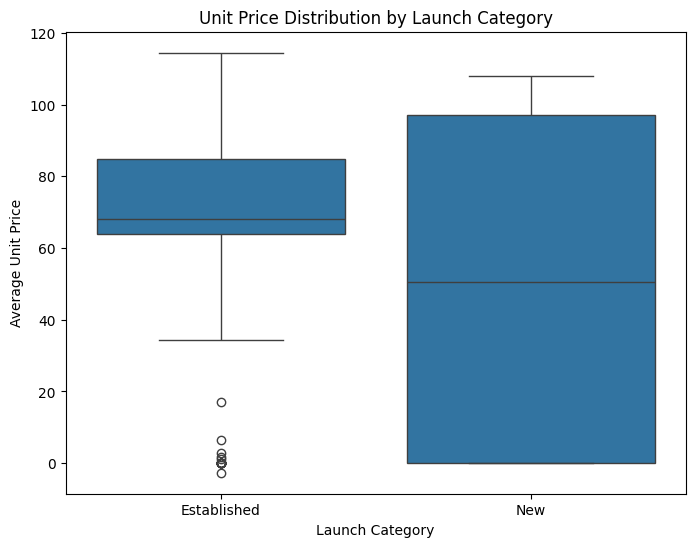

In [25]:

sku_data['launch_category'] = np.where(sku_data['created_date'] >= cutoff_date, 'New', 'Established')

# Boxplot for Average Unit Price by Launch Category
plt.figure(figsize=(8,6))
sns.boxplot(x='launch_category', y='avg_unit_price', data=sku_data)
plt.title('Unit Price Distribution by Launch Category')
plt.xlabel('Launch Category')
plt.ylabel('Average Unit Price')
plt.show()


SKUs are classified as “New” or “Established” based on a cutoff date. Two visualizations are produced: a boxplot of average unit prices by launch category and a violin plot of total sales volume by launch category. The boxplot reveals differences in pricing strategies or market positioning between new and established products, while the violin plot provides insight into the distribution and density of sales volumes across the two groups. 

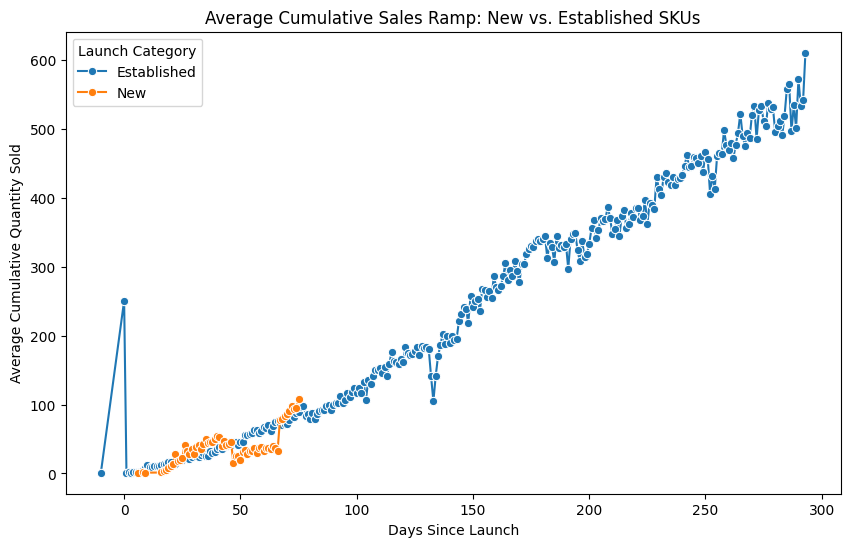

In [26]:
# Get launch dates for all SKUs from the products table
sku_launch_dates = products[['sku', 'created_date']]

# Merge these launch dates into the full orders_line_items dataset
orders_line_all = orders_line_items.merge(
    sku_launch_dates,
    on='sku',
    how='left'
)

# Compute days since launch for every order (for all SKUs)
orders_line_all['days_since_launch'] = (
    orders_line_all['order_date'] - orders_line_all['created_date']
).dt.days

# Aggregate daily sales for each SKU (across all SKUs)
daily_sales_all = (
    orders_line_all
    .groupby(['sku', 'days_since_launch'], as_index=False)['quantity']
    .sum()
    .sort_values(['sku', 'days_since_launch'])
)

# Compute cumulative sales per SKU
daily_sales_all['cumulative_qty'] = (
    daily_sales_all.groupby('sku')['quantity'].cumsum()
)

# Define the cutoff date for new vs. established SKUs (adjust as needed)
cutoff_date = pd.Timestamp('2024-05-01', tz='UTC')

# Merge back the created_date (if needed) and classify each SKU
daily_sales_all = daily_sales_all.merge(sku_launch_dates, on='sku', how='left')
daily_sales_all['launch_category'] = np.where(
    daily_sales_all['created_date'] >= cutoff_date,
    'New',
    'Established'
)

# Compute the average cumulative sales ramp by days_since_launch and launch category
avg_ramp_all = (
    daily_sales_all
    .groupby(['launch_category', 'days_since_launch'])['cumulative_qty']
    .mean()
    .reset_index()
)

# Plot the average cumulative sales ramp for New vs. Established SKUs
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=avg_ramp_all,
    x='days_since_launch',
    y='cumulative_qty',
    hue='launch_category',
    marker='o'
)
plt.title("Average Cumulative Sales Ramp: New vs. Established SKUs")
plt.xlabel("Days Since Launch")
plt.ylabel("Average Cumulative Quantity Sold")
plt.legend(title='Launch Category')
plt.show()


the code extends the analysis to all SKUs by merging launch dates with the orders data, computing daily cumulative sales, and classifying each SKU by its launch category. By grouping these results by days since launch and calculating the mean cumulative sales for each group, the code produces a line plot comparing the average cumulative ramp for new versus established SKUs. This visualization highlights systematic differences in sales trajectories based on product age, helping to pinpoint trends that might inform inventory management, marketing, or product development strategies.

In [27]:
inspect_dataset("sku", sku_data)



sku Dataset Overview:

HEAD:
           sku                        name                id  \
0  AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1  AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2  AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3  AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4  AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   

               created_date  unit_quantity  awaiting  onhand  committed  \
0 2024-03-06 06:00:00+00:00            129         0     129          0   
1 2024-04-09 05:00:00+00:00              1         0       0          0   
2 2024-03-06 06:00:00+00:00              6         0       6          0   
3 2024-03-06 06:00:00+00:00             63         0      63          0   
4 2024-03-06 06:00:00+00:00             34         0      34          0   

   unfulfillable  fulfillable  unsellable  sellable  \
0              0          129           0       129   
1              0            0

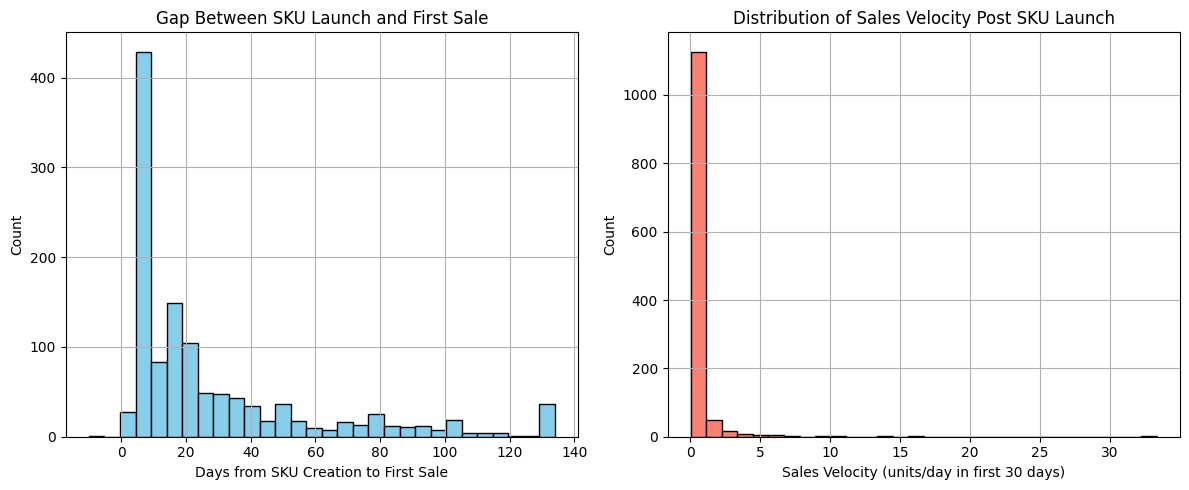

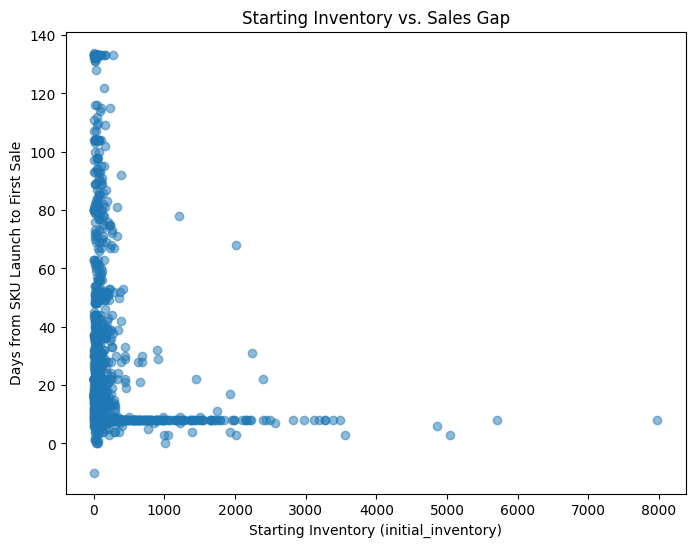

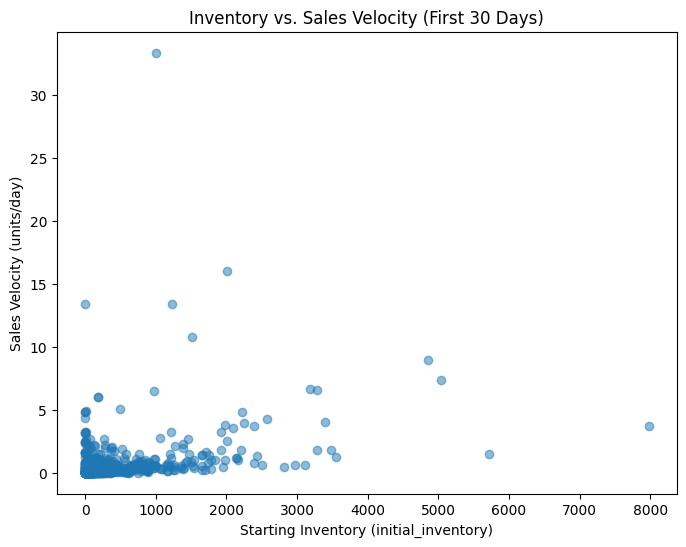

In [28]:
# This function extracts the first sale date from the order_history.
def get_first_sale_date(order_history):
    if not order_history or order_history == "No Sales": # If no sales, return Not-a-Time (NaT)
        return pd.NaT
    if isinstance(order_history, str): # If the order_history is stored as a string, convert it to a list
        try:
            order_history = ast.literal_eval(order_history)
        except Exception as e:
            return pd.NaT
    dates = [entry[0] for entry in order_history if entry[0] is not None] # Extract the dates from the history
    return min(dates) if dates else pd.NaT

sku_data['first_sale_date'] = sku_data['order_history'].apply(get_first_sale_date) # create a new column: first_sale_date

# Compute the Gap Between SKU Creation and First Sale
sku_data['sale_gap_days'] = (sku_data['first_sale_date'] - sku_data['created_date']).dt.days

# Compute the sales velocity (units sold per day) in a fixed window (30 days)
def compute_velocity(order_history, first_sale_date, window=30):
    
    if pd.isna(first_sale_date) or not order_history or order_history == "No Sales": # If no valid first sale date or order history, return NaN
        return np.nan
    if isinstance(order_history, str):
        try:
            order_history = ast.literal_eval(order_history)
        except Exception as e:
            return np.nan
    window_end = first_sale_date + timedelta(days=window)
    total_quantity = sum(entry[1] for entry in order_history if first_sale_date <= entry[0] <= window_end) # Sum quantities for orders that occurred within the window [first_sale_date, window_end]
    return total_quantity / window     # Return average daily sales (units per day) over the window

# Apply the compute_velocity function to each row in the DataFrame
sku_data['velocity_30d'] = sku_data.apply(lambda row: compute_velocity(row['order_history'], row['first_sale_date']), axis=1)


# Plot histogram for the gap (in days) between SKU creation and first sale.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sku_data['sale_gap_days'].dropna().hist(bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Days from SKU Creation to First Sale')
plt.ylabel('Count')
plt.title('Gap Between SKU Launch and First Sale')

# Plot histogram for the sales velocity (units/day in first 30 days)
plt.subplot(1, 2, 2)
sku_data['velocity_30d'].dropna().hist(bins=30, color='salmon', edgecolor='black')
plt.xlabel('Sales Velocity (units/day in first 30 days)')
plt.ylabel('Count')
plt.title('Distribution of Sales Velocity Post SKU Launch')
plt.tight_layout()
plt.show()

# Plotting with non-negative initial inventory
plot_df = sku_data[sku_data['initial_inventory'] >= 0].copy()

# Scatter plot: Starting inventory vs. gap between launch and first sale.
plt.figure(figsize=(8, 6))
plt.scatter(plot_df['initial_inventory'], plot_df['sale_gap_days'], alpha=0.5)
plt.xlabel('Starting Inventory (initial_inventory)')
plt.ylabel('Days from SKU Launch to First Sale')
plt.title('Starting Inventory vs. Sales Gap')
plt.show()

# Scatter plot: Starting inventory vs. sales velocity in first 30 days.
plt.figure(figsize=(8, 6))
plt.scatter(plot_df['initial_inventory'], plot_df['velocity_30d'], alpha=0.5)
plt.xlabel('Starting Inventory (initial_inventory)')
plt.ylabel('Sales Velocity (units/day)')
plt.title('Inventory vs. Sales Velocity (First 30 Days)')
plt.show()


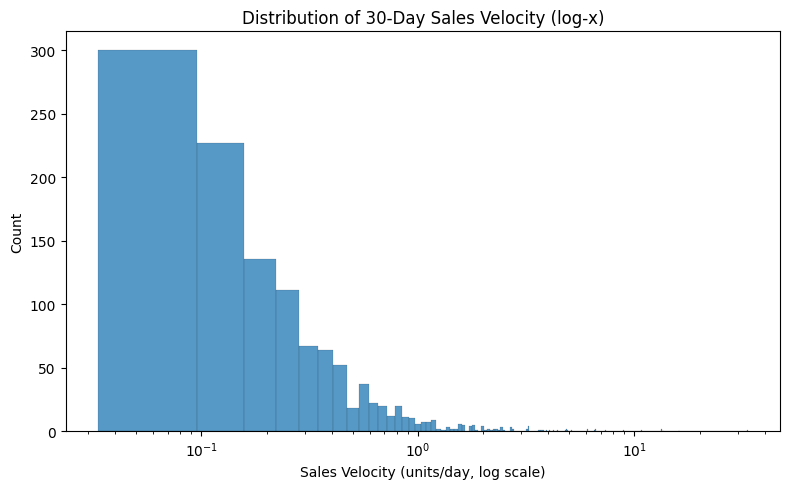

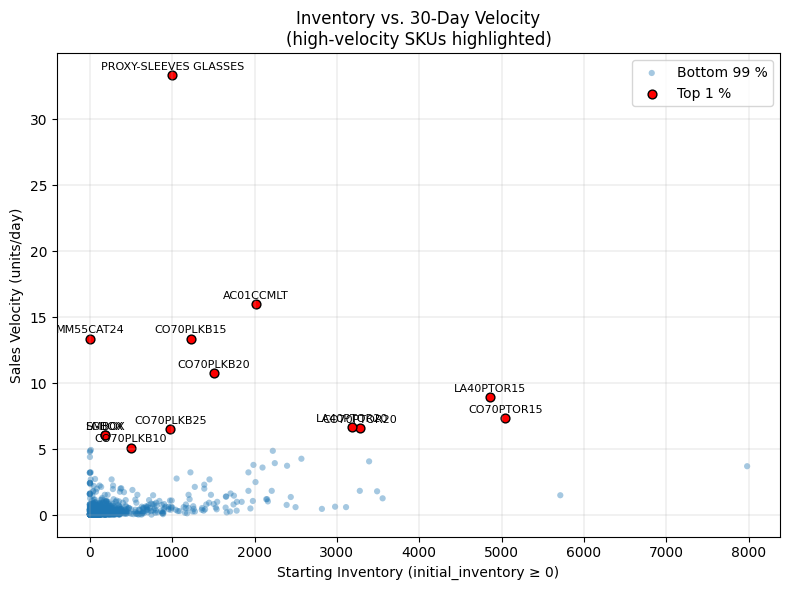

In [29]:
# -----------------------------------------------------------------
# Histogram of velocity_30d on a log‑x scale
# -----------------------------------------------------------------
vel = sku_data['velocity_30d'].dropna()
vel_pos = vel[vel > 0]                # log(0) is undefined → keep positives only

plt.figure(figsize=(8, 5))
sns.histplot(vel_pos, edgecolor='black')
plt.xscale('log')                     # <- key line for log scale
plt.xlabel('Sales Velocity (units/day, log scale)')
plt.ylabel('Count')
plt.title('Distribution of 30‑Day Sales Velocity (log‑x)')
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------
# Scatter: initial inventory vs 30‑day velocity
# Top 1 % velocities highlighted & labelled
# -----------------------------------------------------------------
plot_df = sku_data[sku_data['initial_inventory'] >= 0].copy()
q99 = plot_df['velocity_30d'].quantile(0.99)   # 99th‑percentile threshold
top = plot_df[plot_df['velocity_30d'] >= q99]
base = plot_df[plot_df['velocity_30d'] < q99]

plt.figure(figsize=(8, 6))

# bulk of the data
plt.scatter(base['initial_inventory'], base['velocity_30d'],
            alpha=0.4, s=20, edgecolors='none', label='Bottom 99 %')

# top 1 %
plt.scatter(top['initial_inventory'], top['velocity_30d'],
            color='red', s=40, edgecolors='black', label='Top 1 %')

# optional: annotate each top‑1 % point with SKU
for _, r in top.iterrows():
    plt.text(r['initial_inventory'], r['velocity_30d'] + 0.4,
             r['sku'], fontsize=8, ha='center')

plt.xlabel('Starting Inventory (initial_inventory ≥ 0)')
plt.ylabel('Sales Velocity (units/day)')
plt.title('Inventory vs. 30‑Day Velocity\n(high‑velocity SKUs highlighted)')
plt.legend()
plt.grid(True, linewidth=0.25)
plt.tight_layout()
plt.show()


In [30]:
inspect_dataset("sku", sku_data)


sku Dataset Overview:

HEAD:
           sku                        name                id  \
0  AB10BBLK00    Abbey Blue-light Black 0  AB10BBLK00_20494   
1  AB10BBLK10    Abbey Blue-light Black 1  AB10BBLK10_20494   
2  AB10BBLK15  Abbey Blue-light Black 1.5  AB10BBLK15_20494   
3  AB10BBLK20    Abbey Blue-light Black 2  AB10BBLK20_20494   
4  AB10BBLK30    Abbey Blue-light Black 3  AB10BBLK30_20494   

               created_date  unit_quantity  awaiting  onhand  committed  \
0 2024-03-06 06:00:00+00:00            129         0     129          0   
1 2024-04-09 05:00:00+00:00              1         0       0          0   
2 2024-03-06 06:00:00+00:00              6         0       6          0   
3 2024-03-06 06:00:00+00:00             63         0      63          0   
4 2024-03-06 06:00:00+00:00             34         0      34          0   

   unfulfillable  fulfillable  unsellable  sellable  \
0              0          129           0       129   
1              0            0

Inventory Level Ranges:
Low: -1580.00 to 25.50
Medium: 25.50 to 74.00
High: 74.00 to 212.00
Very High: 212.00 to 7980.00


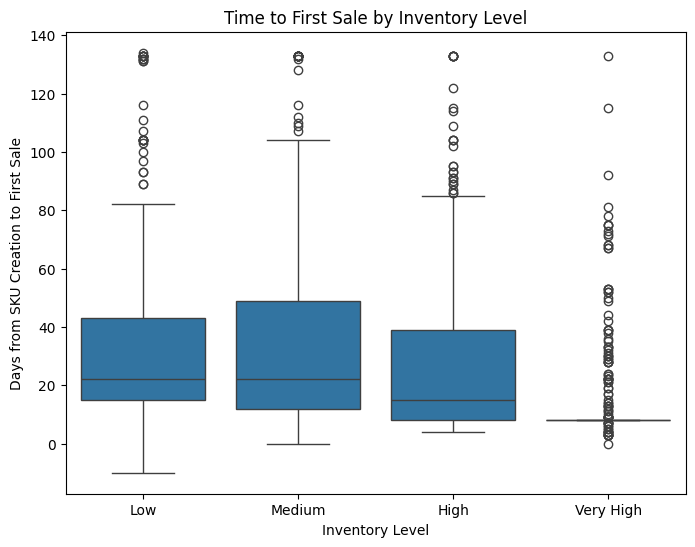

In [31]:
# Categorize SKUs based on unit_quantity (starting inventory) and capture bin edges
sku_data['inventory_category'], bin_edges = pd.qcut(sku_data['initial_inventory'], q=4, labels=['Low', 'Medium', 'High', 'Very High'], retbins=True)

# Print out the bin edges for reference
print("Inventory Level Ranges:")
for i in range(len(bin_edges)-1):
    print(f"{sku_data['inventory_category'].cat.categories[i]}: {bin_edges[i]:.2f} to {bin_edges[i+1]:.2f}")

# Compare sale gap days by inventory category
plt.figure(figsize=(8,6))
sns.boxplot(x='inventory_category', y='sale_gap_days', data=sku_data)
plt.title('Time to First Sale by Inventory Level')
plt.xlabel('Inventory Level')
plt.ylabel('Days from SKU Creation to First Sale')
plt.show()


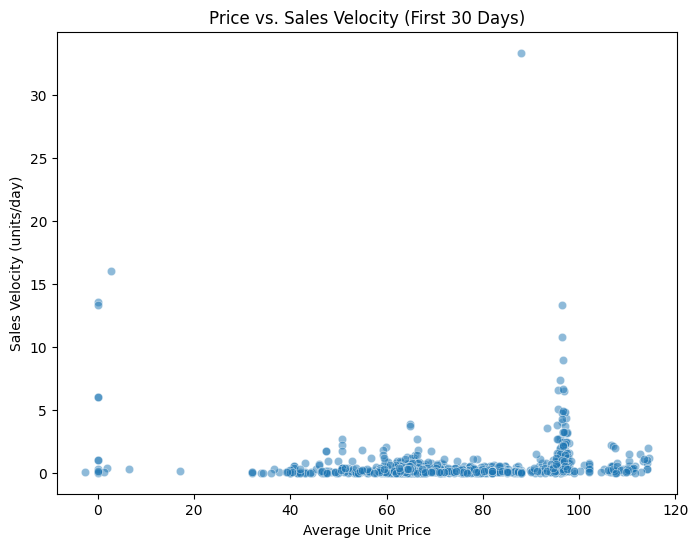

Correlation between price and sales velocity: 0.04


In [32]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=sku_data['avg_unit_price'], y=sku_data['velocity_30d'], alpha=0.5)
plt.title('Price vs. Sales Velocity (First 30 Days)')
plt.xlabel('Average Unit Price')
plt.ylabel('Sales Velocity (units/day)')
plt.show()

# Calculate correlation
price_velocity_corr = sku_data[['avg_unit_price', 'velocity_30d']].corr().iloc[0,1]
print(f"Correlation between price and sales velocity: {price_velocity_corr:.2f}")


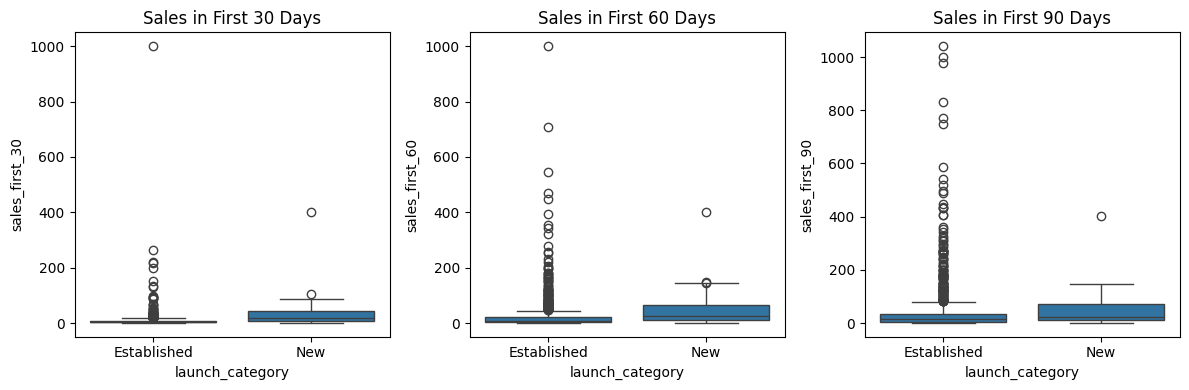

In [33]:
# Compute sales in first 30, 60, 90 days for all SKUs
def get_growth_metric(sales_df, days):
    metric = sales_df[sales_df['days_since_launch'] <= days] \
                .groupby('sku')['quantity'] \
                .sum() \
                .reset_index(name=f'sales_first_{days}')
    return metric

growth_30 = get_growth_metric(daily_sales_all, 30)
growth_60 = get_growth_metric(daily_sales_all, 60)
growth_90 = get_growth_metric(daily_sales_all, 90)

# Merge with SKU data
growth_metrics = growth_30.merge(growth_60, on='sku', how='outer') \
                          .merge(growth_90, on='sku', how='outer') \
                          .merge(sku_data[['sku', 'launch_category']], on='sku', how='left')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x='launch_category', y='sales_first_30', data=growth_metrics)
plt.title('Sales in First 30 Days')

plt.subplot(1, 3, 2)
sns.boxplot(x='launch_category', y='sales_first_60', data=growth_metrics)
plt.title('Sales in First 60 Days')

plt.subplot(1, 3, 3)
sns.boxplot(x='launch_category', y='sales_first_90', data=growth_metrics)
plt.title('Sales in First 90 Days')

plt.tight_layout()
plt.show()


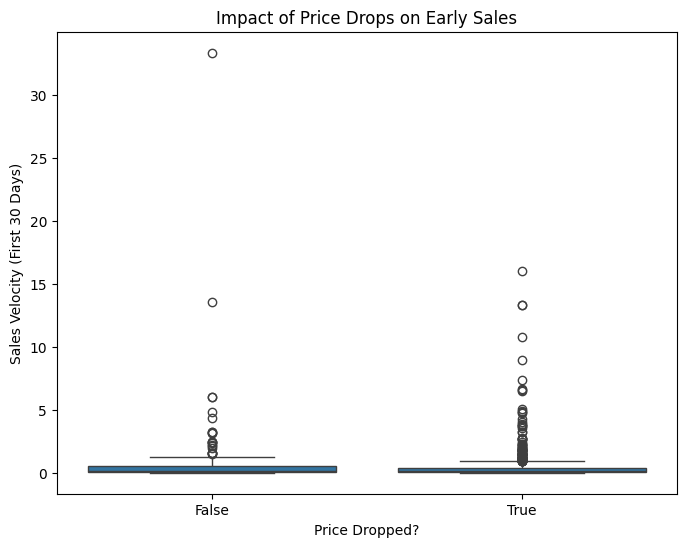

In [34]:
sku_data['price_drop'] = sku_data['order_history'].apply(lambda x: any(entry[2] < sku_data['avg_unit_price'].mean() for entry in x if isinstance(x, list)))

plt.figure(figsize=(8,6))
sns.boxplot(x='price_drop', y='velocity_30d', data=sku_data)
plt.title('Impact of Price Drops on Early Sales')
plt.xlabel('Price Dropped?')
plt.ylabel('Sales Velocity (First 30 Days)')
plt.show()


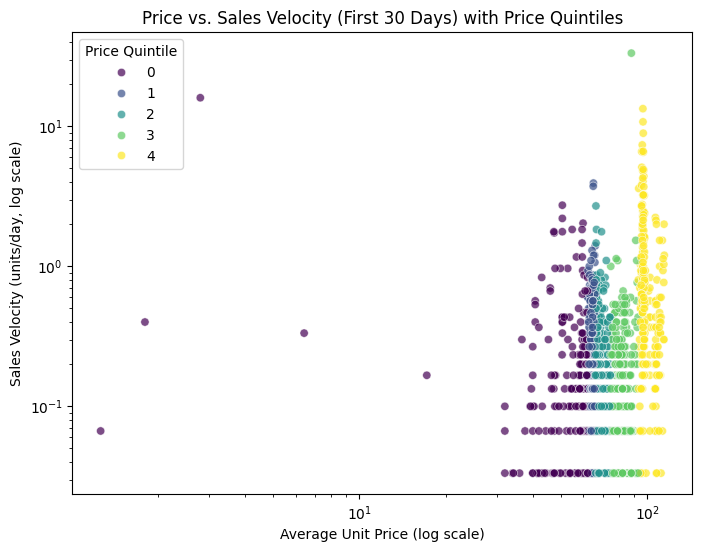

In [35]:
# Log-Scaled Price vs. Sales Velocity with Price Quintiles
sku_data['price_quintile'] = pd.qcut(sku_data['avg_unit_price'], 5, labels=False, duplicates='drop')

plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_unit_price', y='velocity_30d', 
                hue='price_quintile', 
                palette='viridis', 
                data=sku_data, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Average Unit Price (log scale)')
plt.ylabel('Sales Velocity (units/day, log scale)')
plt.title('Price vs. Sales Velocity (First 30 Days) with Price Quintiles')
plt.legend(title='Price Quintile')
plt.show()

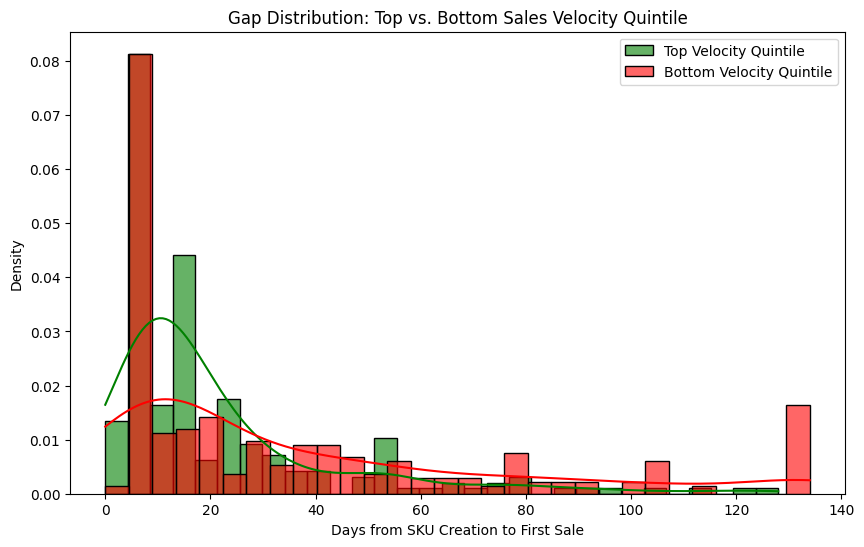

In [36]:
# Compare Gap Distribution: Top vs. Bottom Sales Velocity Quintiles

sku_data_clean = sku_data.dropna(subset=['velocity_30d']).copy()
sku_data_clean['velocity_quintile'] = pd.qcut(sku_data_clean['velocity_30d'], 5, labels=False, duplicates='drop')

# Extract gap days for top and bottom velocity quintiles
top_velocity_gap = sku_data_clean[sku_data_clean['velocity_quintile'] == sku_data_clean['velocity_quintile'].max()]['sale_gap_days']
bottom_velocity_gap = sku_data_clean[sku_data_clean['velocity_quintile'] == sku_data_clean['velocity_quintile'].min()]['sale_gap_days']

plt.figure(figsize=(10,6))
sns.histplot(top_velocity_gap, color='green', label='Top Velocity Quintile', kde=True, stat="density", bins=30, alpha=0.6)
sns.histplot(bottom_velocity_gap, color='red', label='Bottom Velocity Quintile', kde=True, stat="density", bins=30, alpha=0.6)
plt.xlabel('Days from SKU Creation to First Sale')
plt.ylabel('Density')
plt.title('Gap Distribution: Top vs. Bottom Sales Velocity Quintile')
plt.legend()
plt.show()


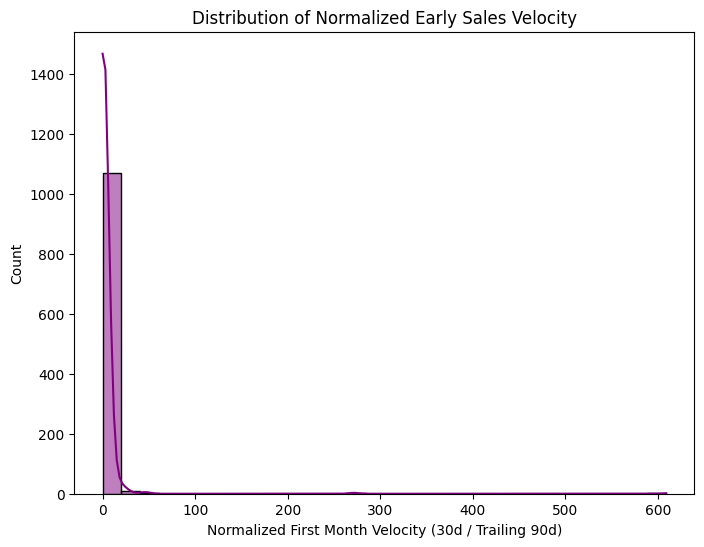

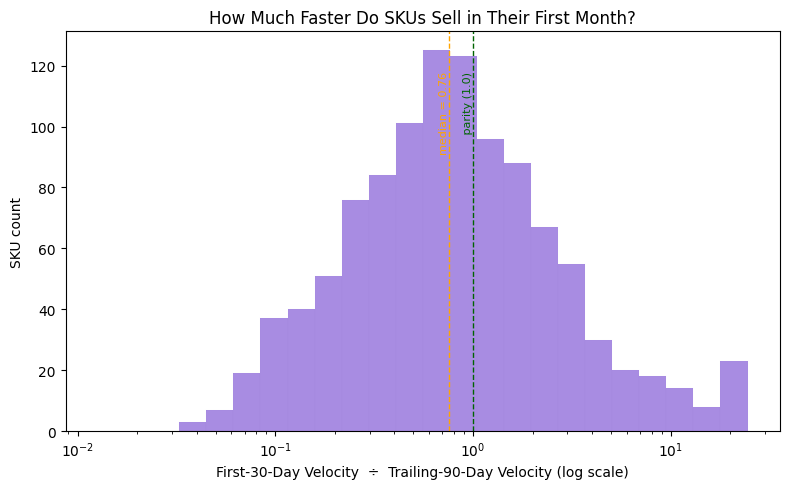

In [37]:
# Normalizing Post-Launch Sales Velocity

def compute_velocity_window(order_history, start_date, window_days):
    """
    Computes average daily sales (velocity) over a specified window.
    """
    if pd.isna(start_date) or not order_history or order_history == "No Sales":
         return np.nan
    # Convert from string if needed
    if isinstance(order_history, str):
         try:
              order_history = ast.literal_eval(order_history)
         except Exception:
              return np.nan
    window_end = start_date + timedelta(days=window_days)
    total_quantity = sum(entry[1] for entry in order_history if start_date <= entry[0] < window_end)
    return total_quantity / window_days

# Compute trailing 90-day velocity starting from day 31 after first sale
sku_data['trailing_90d_velocity'] = sku_data.apply(
    lambda row: compute_velocity_window(row['order_history'], row['first_sale_date'] + timedelta(days=30), 90) 
                if pd.notna(row['first_sale_date']) else np.nan, axis=1)

# Calculate normalized metric: first 30-day velocity divided by trailing 90-day velocity
sku_data['normalized_velocity'] = sku_data['velocity_30d'] / sku_data['trailing_90d_velocity']

plt.figure(figsize=(8,6))
sns.histplot(sku_data['normalized_velocity'].dropna(), bins=30, kde=True, color='purple', edgecolor='black')
plt.xlabel('Normalized First Month Velocity (30d / Trailing 90d)')
plt.title('Distribution of Normalized Early Sales Velocity')
plt.show()

# ---------------------------------------------------------------
# 1.  Clean the ratio so the axis makes sense
#    • drop inf / nan
#    • cap at an upper bound (e.g. P99) so the log scale isn’t 1‑1000
# ---------------------------------------------------------------
ratio = sku_data['normalized_velocity'].replace([np.inf, -np.inf], np.nan).dropna()

# optional: restrict to the central 99 % to avoid super‑long tails
upper_cap = ratio.quantile(0.99)
ratio_clipped = ratio.clip(upper=upper_cap)

# ---------------------------------------------------------------
# 2.  Make a log‑x histogram with fewer, log‑spaced bins
# ---------------------------------------------------------------
bins = np.logspace(np.log10(ratio_clipped.min()),
                   np.log10(ratio_clipped.max()), 25)   # 25 log‑bins

plt.figure(figsize=(8, 5))
sns.histplot(ratio_clipped, bins=bins, color='mediumpurple',
             edgecolor='black', alpha=0.8)

plt.xscale('log')
plt.xlabel('First‑30‑Day Velocity  ÷  Trailing‑90‑Day Velocity (log scale)')
plt.ylabel('SKU count')
plt.title('How Much Faster Do SKUs Sell in Their First Month?')

# ---------------------------------------------------------------
# 3.  Add reference lines / annotations
# ---------------------------------------------------------------
plt.axvline(1, color='darkgreen', linestyle='--', linewidth=1)
plt.text(1, plt.ylim()[1]*0.9, ' parity (1.0)', rotation=90,
         va='top', ha='right', fontsize=8, color='darkgreen')

median = ratio_clipped.median()
plt.axvline(median, color='orange', linestyle='--', linewidth=1)
plt.text(median, plt.ylim()[1]*0.9, f'median = {median:0.2f}',
         rotation=90, va='top', ha='right', fontsize=8, color='orange')

plt.tight_layout()
plt.show()


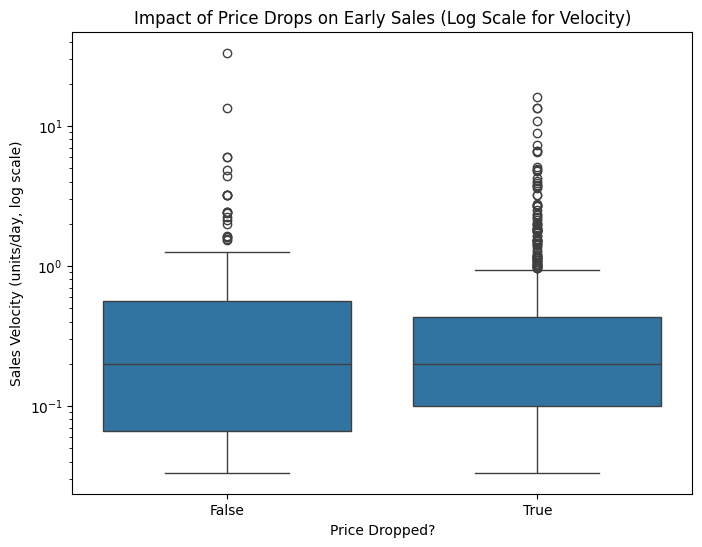

In [38]:
# Impact of Price Drops on Early Sales (with Log Scale)
plt.figure(figsize=(8,6))
sns.boxplot(x='price_drop', y='velocity_30d', data=sku_data)
plt.yscale('log')
plt.title('Impact of Price Drops on Early Sales (Log Scale for Velocity)')
plt.xlabel('Price Dropped?')
plt.ylabel('Sales Velocity (units/day, log scale)')
plt.show()

In [39]:
sku_data


,sku,name,id,created_date,unit_quantity,awaiting,onhand,committed,unfulfillable,fulfillable,unsellable,sellable,unit_quantity_matches_sellable,total_quantity_sold,avg_unit_price,order_history,receipts_after,initial_inventory,launch_category,first_sale_date,sale_gap_days,velocity_30d,inventory_category,price_drop,price_quintile,trailing_90d_velocity,normalized_velocity
0,AB10BBLK00,Abbey Blue-light Black 0,AB10BBLK00_20494,2024-03-06 06:00:00+00:00,129,0,129,0,0,129,0,129,True,33.0,52.909091,"[(2024-04-03 17:03:00+00:00, 1, 42.0), (2024-0...",0.0,162.0,Established,2024-04-03 17:03:00+00:00,28.0,0.966667,High,True,0,0.044444,21.750000
1,AB10BBLK10,Abbey Blue-light Black 1,AB10BBLK10_20494,2024-04-09 05:00:00+00:00,1,0,0,0,0,0,0,0,False,6.0,71.333333,"[(2024-04-19 00:06:00+00:00, 1, 88.0), (2024-0...",0.0,7.0,Established,2024-04-19 00:06:00+00:00,9.0,0.066667,Low,True,2,0.044444,1.500000
2,AB10BBLK15,Abbey Blue-light Black 1.5,AB10BBLK15_20494,2024-03-06 06:00:00+00:00,6,0,6,0,0,6,0,6,True,20.0,54.222222,"[(2024-03-30 07:17:00+00:00, 1, 66.0), (2024-0...",0.0,26.0,Established,2024-03-30 07:17:00+00:00,24.0,0.100000,Medium,True,0,0.188889,0.529412
3,AB10BBLK20,Abbey Blue-light Black 2,AB10BBLK20_20494,2024-03-06 06:00:00+00:00,63,0,63,0,0,63,0,63,True,23.0,72.752174,"[(2024-03-29 18:22:00+00:00, 1, 88.0), (2024-0...",0.0,86.0,Established,2024-03-29 18:22:00+00:00,23.0,0.100000,High,True,2,0.222222,0.450000
4,AB10BBLK30,Abbey Blue-light Black 3,AB10BBLK30_20494,2024-03-06 06:00:00+00:00,34,0,34,0,0,34,0,34,True,6.0,88.000000,"[(2024-03-27 15:42:00+00:00, 1, 88.0), (2024-0...",0.0,40.0,Established,2024-03-27 15:42:00+00:00,21.0,0.033333,Medium,False,3,0.055556,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,WI80SBLK15,Wills Sun Black 1.5,WI80SBLK15_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False,11.0,80.181818,"[(2024-03-22 22:01:00+00:00, 1, 82.0), (2024-0...",0.0,12.0,Established,2024-03-22 22:01:00+00:00,16.0,0.200000,Low,True,3,0.055556,3.600000
1263,WI80SBLK20,Wills Sun Black 2,WI80SBLK20_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False,5.0,82.000000,"[(2024-03-20 16:42:00+00:00, 1, 82.0), (2024-0...",0.0,6.0,Established,2024-03-20 16:42:00+00:00,14.0,0.166667,Low,False,3,0.000000,inf
1264,WI80SBLK25,Wills Sun Black 2.5,WI80SBLK25_20494,2024-04-09 05:00:00+00:00,1,0,0,0,0,0,0,0,False,5.0,82.000000,"[(2024-04-27 13:25:00+00:00, 1, 82.0), (2024-0...",0.0,6.0,Established,2024-04-27 13:25:00+00:00,18.0,0.133333,Low,False,3,0.011111,12.000000
1265,WI80SNTP10,Wills Sun Navy Taupe 1,WI80SNTP10_20494,2024-03-06 06:00:00+00:00,1,0,0,0,0,0,0,0,False,1.0,82.000000,"[(2024-06-21 08:26:00+00:00, 1, 82.0)]",0.0,2.0,Established,2024-06-21 08:26:00+00:00,107.0,0.033333,Low,False,3,0.000000,inf
